# Utils

In [1]:
from shapely.geometry import Point
import random
random.seed()


def get_bounding_box(row, gdf):
    aoi = Point(row.geometry.centroid.x, row.geometry.centroid.y).buffer(4750, cap_style=3)
    neighbors = gdf.clip(aoi)
    neighbors = neighbors.append(row)

    return neighbors, aoi

def get_random_bounding_box(gdf, gdf_ref):
    random_row = random.choice(gdf_ref.index.tolist())
    row = gdf_ref.loc[[random_row]]
    return get_bounding_box(row, gdf)

def compute_IoU(bounds1, bounds2):
    if bounds1.intersects(bounds2):
        IoU = bounds1.intersection(bounds2).area / bounds1.union(bounds2).area
    else: 
        IoU = 0
        
    return IoU

# Load data

In [2]:
import geopandas as gpd
import pandas as pd
from datetime import datetime
import os 

utm = 32631

directory = '/Users/arthurcalvi/Data/results/disturbances/matching_france_v04_EPSG3857.parquet'
#Load disturbances, convert to utm coordinates 
gdf = gpd.read_parquet(directory)

#filtering duplicates
gdf.drop_duplicates(subset=['index_SS', 'year'], inplace=True)
gdf.shape[0]


5870700

In [3]:
gdf = gdf.to_crs(epsg=utm)

In [2]:
#Load greco regions


from shapely.ops import unary_union
#load greco
file = '/Users/arthurcalvi/Data/eco-regions/France/ser_l93_new/ser_l93_new.shp'
greco = gpd.read_file(file)

greco['GRECO'] = greco['codeser'].apply(lambda x: x[0])

#group polygon by the column GRECO
greco = greco.dissolve(by='GRECO')
greco.reset_index(inplace=True)
#drop étang de berre
greco = greco[greco['GRECO'] != '-']
greco.geometry = greco.geometry.normalize()
greco.geometry = greco.geometry.apply(unary_union)
#to UTM
greco = greco.to_crs(epsg=utm)


[nominatim] downloading data: search


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


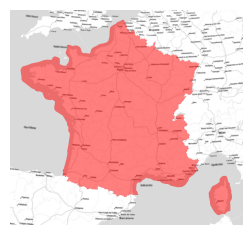

In [5]:
#les landes
#autorelaod
%load_ext autoreload
%autoreload 2
from utils2 import get_polygon

region_name = 'France métropolitaine'
region1, spatial_entity1 = get_polygon(region_name, epsg=utm)
# gironde, spatial_entity2 = get_polygon('Gironde, France', epsg=utm)

#put into a geodataframe with two columns geometry and name
region1 = gpd.GeoDataFrame(geometry=[region1], crs='EPSG:{}'.format(utm))
region1['name'] = region_name

# gironde = gpd.GeoDataFrame(geometry=[gironde], crs='EPSG:{}'.format(utm))
# gironde['name'] = 'Gironde'

# #merge
# landes = landes.append(gironde)
# landes.reset_index(inplace=True)
#plot les landes with base maps from contextily

import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))
region1.plot(ax=ax, color='red', alpha=0.5)
ax.set_axis_off()
ctx.add_basemap(ax, crs=region1.crs.to_string(), source=ctx.providers.Stamen.TonerLite, attribution=False)

# Sampling

As stated by Cornelius Senf, the classifier is not as good on the test set as on real data. A lot of disturbances classified as fire are indeed insect attacks. So the Overal accuracy should be considered lower than 0.92. The classifier is not as good as it seems.

<Axes: xlabel='probability', ylabel='class'>

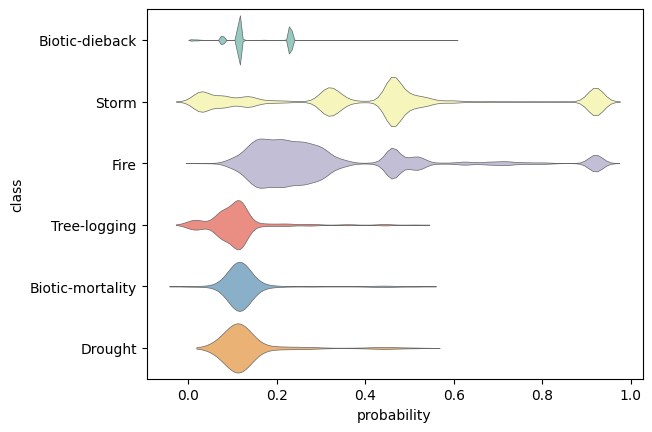

In [20]:
#violin plot discribing the probability (gdf['probability']) for each unique item of gdf['class']
import seaborn as sns
sns.violinplot(y=gdf['class'], x=gdf['probability'],  \
               palette="Set3", scale='width', bw='silverman', \
                linewidth=0.5, inner=None)


In [47]:
#Parameters 

dir_ = '/Users/arthurcalvi/Data/sampling/france'
os.makedirs(dir_, exist_ok=True)
n = 100
regions = region1
col_region = 'name'
name_dict = 'dict_aoi_france.pkl '
gdf_ = gdf[ (gdf.year >= 2018)&(gdf.year <= 2020) ] 

classes = gdf_['class'].unique().tolist()
gdf_ = gdf_[gdf_['class'].isin(classes)]
n_class = len(classes)
n_region = regions[col_region].unique().shape[0]
N = int(n / (n_class * n_region))
print('Nbr of aoi to download per class and per region:', N)

Nbr of aoi to download per class and per region: 6


In [48]:
gdf_ = gdf_[ gdf_.probability > 0.5 ]
gdf_['class'].value_counts()

Fire              1118
Biotic-dieback       6
Name: class, dtype: int64

In [49]:
from datetime import datetime, timedelta, timezone
from rasterio.warp import transform_geom
from shapely.geometry import shape 
import shutil 
from collections import defaultdict
import itertools

#import tqdm notebook
from tqdm.notebook import tqdm

#avoid FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



count_download = 0
delta = timedelta(days=3*365)
first = True

#load set_aoi from pickle and add check for existing file set_aoi.pkl
import pickle
count = 0 
list_aoi = []
dict_aoi = dict()

path = os.path.join(dir_, name_dict)
if os.path.isfile(path):
    with open(path, 'rb') as f:
        dict_aoi = pickle.load(f)
    for key in dict_aoi.keys():
        list_aoi.extend(list(itertools.chain.from_iterable(dict_aoi[key].values())))

    

for region in regions[col_region].unique():
    #simplify geometry
    geometry = regions[regions[col_region] == region].geometry.iloc[0].buffer(7000).simplify(7000)
    gdf_region = gdf_.clip(geometry)

    for cause in tqdm(gdf_region['class'].unique()):
        
        #initailize dict_aoi for region and cause if no key
        dict_aoi.setdefault(region, dict())
        dict_aoi[region].setdefault(cause, [])

        if len(dict_aoi[region][cause]) >= N:
            pass 
        else :
            gdf_class = gdf_region[gdf_region['class'] == cause]
            if gdf_class.shape[0] > 0:
                count += 1 
                for i in range(N):
                    max_IoU = 1.
                    if len(list_aoi) == 0:
                        gdf_neighbors, current_aoi = get_random_bounding_box(gdf_region, gdf_class)
                        max_IoU = 0
                    else:
                        j = 0
                        while max_IoU > 0.01 and j<100:
                            j += 1
                            #get random bounding box
                            try :
                                gdf_neighbors, current_aoi = get_random_bounding_box(gdf_region, gdf_class)
                            except:
                                print('j:', j)
                                break

                            #compute IoUs
                            max_IoU = max([compute_IoU(current_aoi, aoi) for aoi in list_aoi])
                    
                    if max_IoU > 0.01:
                        pass
                    else:
                        #delete row in gdf and gdf_class that are in neighbors
                        gdf_class = gdf_class[~gdf_class.index.isin(gdf_neighbors.index)]
                        gdf_region = gdf_region[~gdf_region.index.isin(gdf_neighbors.index)]
                        gdf = gdf[~gdf.index.isin(gdf_neighbors.index)]

                        #adding new aoi to set
                        dict_aoi[region][cause].append(current_aoi)

                        #dicted aoi is a dict of defaultdict(list), so we need to flatten it into a list
                        for key in dict_aoi.keys():
                            list_aoi.extend(list(itertools.chain.from_iterable(dict_aoi[key].values())))

           
        
# save set_aoi in pickle
with open(os.path.join(dir_, name_dict), 'wb') as f:
    pickle.dump(dict_aoi, f)

  0%|          | 0/1 [00:00<?, ?it/s]

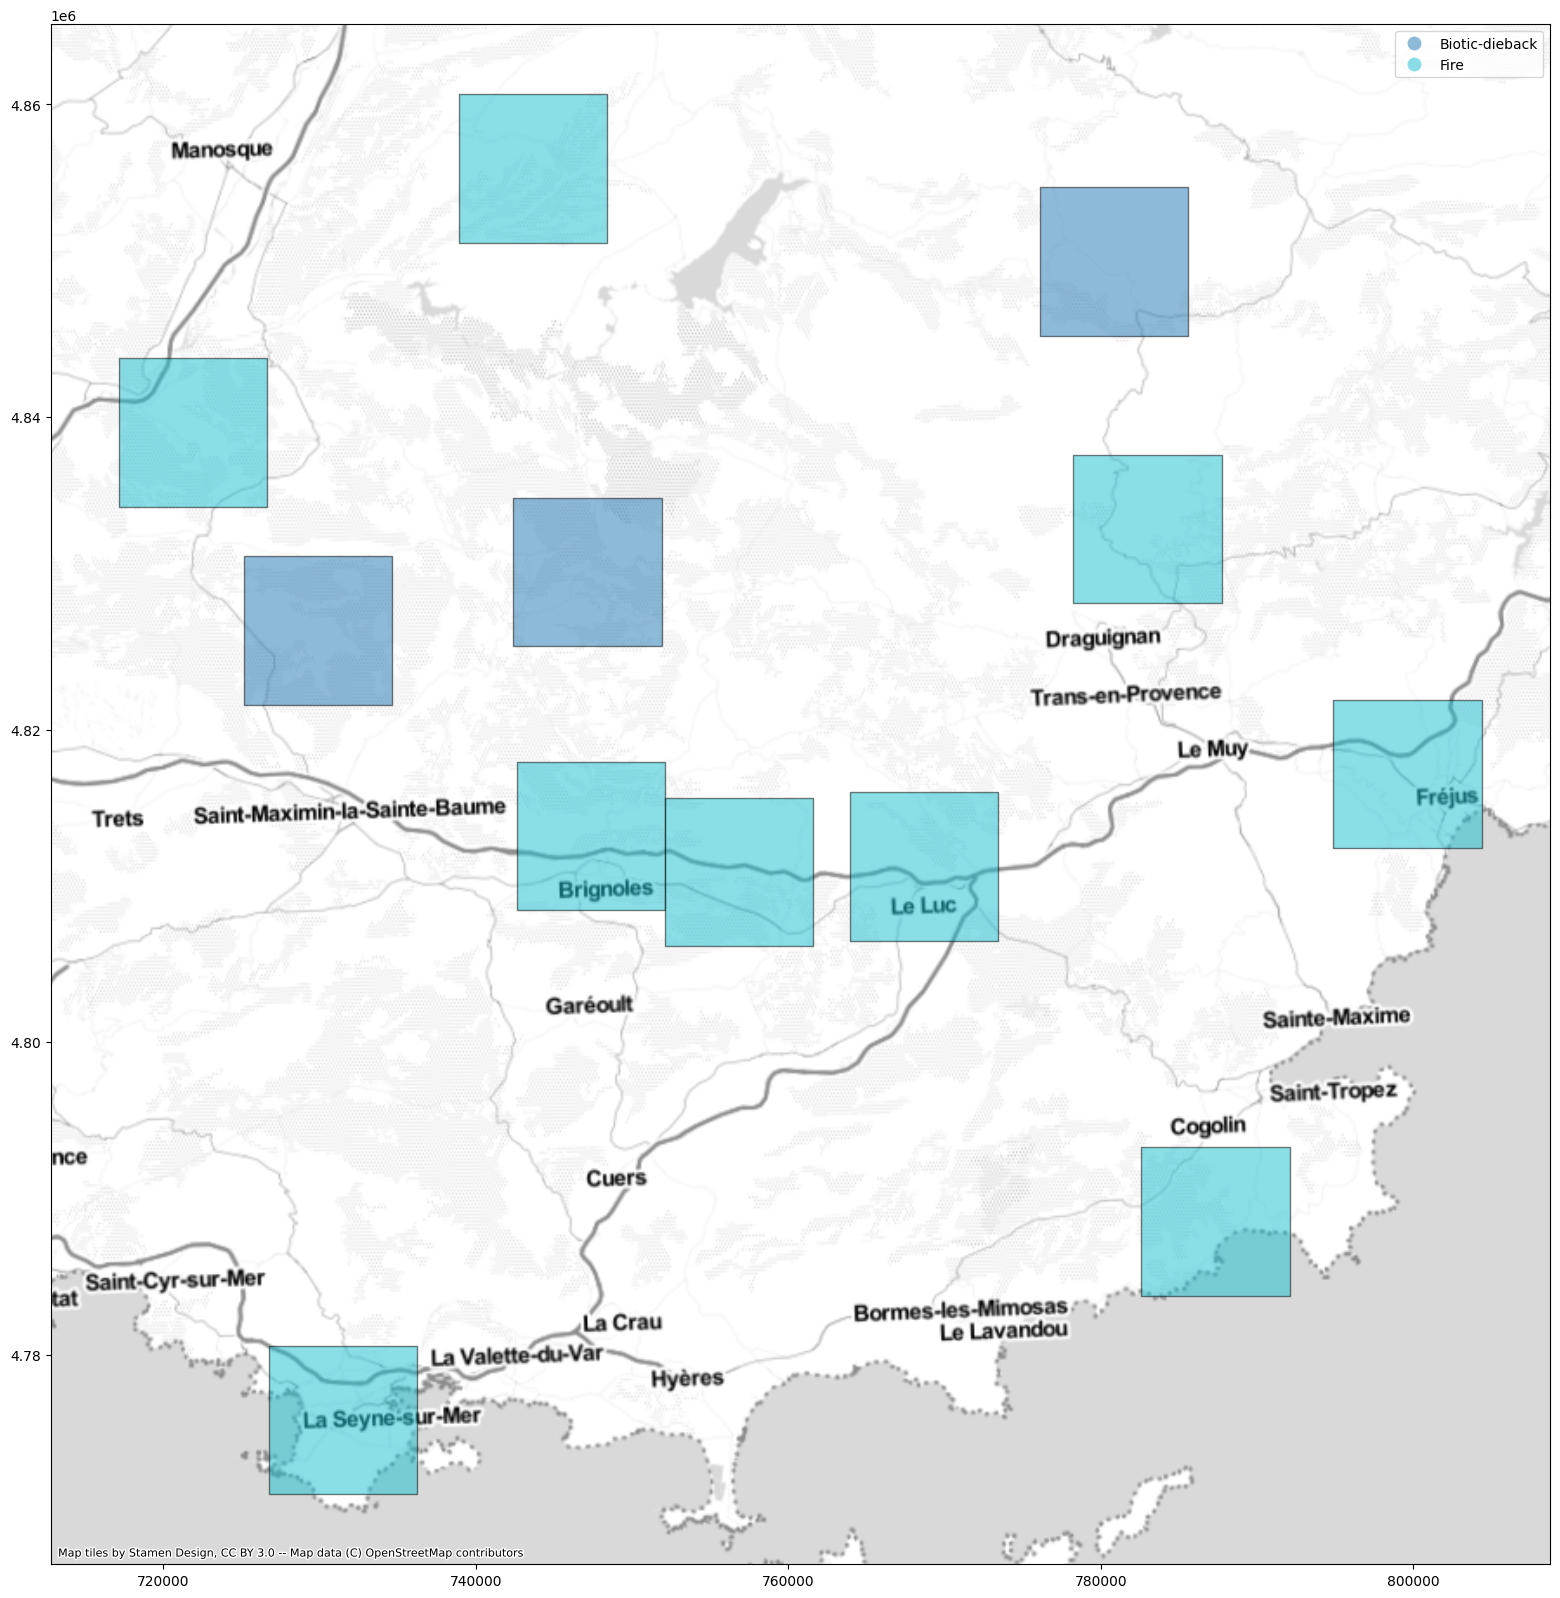

In [50]:
#construt GDF from set_aoi
lgdf = []
for region in dict_aoi.keys():
    for cause in dict_aoi[region].keys():
        gdf_aoi = gpd.GeoDataFrame({'geometry': dict_aoi[region][cause]}, crs='epsg:{}'.format(utm))
        gdf_aoi['region'] = region
        gdf_aoi['cause'] = cause
        lgdf.append(gdf_aoi)

gdf_aoi = pd.concat(lgdf)
#to GeoDataFrame
gdf_aoi = gpd.GeoDataFrame(gdf_aoi, geometry='geometry', crs='epsg:{}'.format(utm))


#plot gdf_aoi with basemap from contextily
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 20)

ax = gdf_aoi.plot(alpha=0.5, edgecolor='k', column='cause', legend=True)
ctx.add_basemap(ax, crs=gdf_aoi.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()

In [29]:
gdf_aoi.crs

<Derived Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich